In [1]:
import os
import glob
#import tqdm
import numpy as np
#import pandas as pd
import multiprocessing
import pydicom as dicom
import nibabel as nib
#from keras import utils as kutils
from matplotlib import pyplot as plt

def load_image(label_fpath, transpose=False):
    #encode_name = label_fpath[-39: -7]
    label_data = nib.load(label_fpath)
    label_array = label_data.get_fdata()
    if transpose:
        label_array = np.transpose(label_array, axes=(2, 1, 0))
    return  label_array#, encode_name

In [2]:
import os
import tensorflow as tf
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
gpu_options = tf.GPUOptions(allow_growth=True)
sess_config = tf.ConfigProto(gpu_options=gpu_options)
tf.keras.backend.set_session(tf.Session(config=sess_config))

In [3]:
ls

basic_info1(boxes_and_xy).ipynb
masking_dilation_boxTumor(newStart).ipynb
tumor_masking_dilation(newStart).ipynb


In [4]:
cd ..

/home/u/wartytw


In [5]:
import pandas as pd
info = pd.read_csv('/data2/pancreas/Nifti_data/data_list.csv')

In [6]:
image_path = "/data2/pancreas/Nifti_data/image"
label_path = "/data2/pancreas/Nifti_data/label"

In [7]:
resec_train = np.load("resec_train.npy")
resec_val = np.load("resec_val.npy")
y_train = np.load("y_train.npy")
y_val = np.load("y_val.npy")

In [8]:
shape_tumor = np.load("box_tumor.npy")

In [9]:
resec = np.concatenate([resec_train, resec_val], axis = 0)

In [10]:
y = np.concatenate([y_train, y_val], axis = 0)

In [11]:
#New
def extract_cube(r, img):#cube 100, 80, 35 ;; ranges = [xmin, xmax, ymin, ymax, zmin, zmax]
    img_tmp = np.zeros((200, 85, 40))
    img_tmp[:int(r[1]-r[0]), :int(r[3]-r[2]), :int(r[5]-r[4])] = img[int(r[0]):int(r[1]), int(r[2]):int(r[3]), int(r[4]):int(r[5])]
    return img_tmp


def masking(label, img):
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if label[i, j] == 0 or label[i, j] == 1:
                img[i, j] = 0
    return img


In [12]:


import pandas as pd
#y_idx => for construct (500, 1) vector
map_df = pd.DataFrame(data={'resec_name': resec, 'shape': np.array(range(len(resec))), 'target':y.reshape(len(resec))})

In [13]:
from keras.models import Model#, load_model
from keras import layers as klayers
from keras.optimizers import Adam
from keras import utils as kutils
from keras import backend as K
from keras.callbacks import ModelCheckpoint



from keras.layers import Conv3D, MaxPool3D, Flatten, Dense
from keras.layers import Dropout, Input, BatchNormalization
from sklearn.metrics import confusion_matrix, accuracy_score
#from plotly.offline import iplot, init_notebook_mode
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta
#import plotly.graph_objs as go
from matplotlib.pyplot import cm
from keras.models import Model
import numpy as np
import keras
import h5py

#init_notebook_mode(connected=True)
%matplotlib inline


from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, concatenate,  MaxPool2D, Reshape
# from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D, Lambda
from keras.layers.advanced_activations import LeakyReLU, ReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv1D
from keras.models import Sequential, Model
from keras.optimizers import Adam, SGD
from keras.utils import to_categorical
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector, Reshape
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline




Using TensorFlow backend.


In [14]:
from keras.utils import to_categorical
from scipy import ndimage
class resec_Generator1(kutils.Sequence):
    'Generates data for Keras'
    def __init__(self, mapping_df, batch_size, shuffle=True):
        'Initialization'
        self.mapping_df = mapping_df
        self.data_num   = mapping_df.shape[0]
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(self.data_num / self.batch_size))


    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        #print("enter0")
        batch_mapping_df = \
            self.mapping_df.iloc[index*self.batch_size: (index+1)*self.batch_size]

        # Generate data
        X, y = self.__data_generation(batch_mapping_df)
        return X, y


    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle:
            self.mapping_df = self.mapping_df.sample(frac=1).reset_index(drop=True)
            
    def __data_generation(self, batch_mapping_df):
        'Generates data containing batch_size samples' 
        # Initialization
        X = np.zeros((  self.batch_size, 200, 85, 40, 1)) 

        y = np.zeros((self.batch_size))

        # Generate data
        cnt = 0
        
        for i, row in batch_mapping_df.iterrows():
            #img = extract_cube(shape_tumor[row['shape']], load_image(os.path.join(image_path, "IM_"+row['resec_name']+".nii.gz")))
            encode = row['resec_name']
            volume_image = load_image(os.path.join(image_path, "IM_"+encode+".nii.gz"))
            label = load_image(os.path.join(label_path, "LB_"+encode+".nii.gz"))
            volume_image1 = extract_cube(shape_tumor[row['shape'], :], volume_image) 
            label1 = extract_cube(shape_tumor[row['shape'], :], label) 
            num_slice = volume_image1.shape[2]
            for _z in range(0, num_slice):
                label11 = ndimage.binary_dilation(label1[:, :, _z]).astype(label1[:, :, _z].dtype)
                volume_image1[..., _z] = masking(label11, volume_image1[..., _z])
                del label11

            #print(encode)
            X[ cnt, :, :, :, 0] = volume_image1
            del volume_image1, label1, volume_image, label
            #img = clip_img(load_image(os.path.join(image_path, "IM_"+row['resec_name']+".nii.gz")))
            #print("resec_name =", row['resec_name'])
#             for j in range(40):
#                 #print("img shape =", img.shape)
#                 #print("j =", j)
#                 X[j][cnt, :, :, :, 0] = extract_cube(img, j)
            y[cnt] = row['target']

#             position = extract_position(row['ref_idx'], row['point_idx'])
#             tmp_cube = extract_cube(position, row['ref_idx'])
#             if (tmp_cube.shape == (19, 19, 19)):
#                 X[cnt, :, :, :, 0] = extract_cube(position, row['ref_idx'])
#             else:
#                 X[cnt, :, :, :, 0] = np.zeros((19, 19, 19))
#             y_idx = row['y_idx']
#             radius = ref[row['ref_idx']][row['point_idx'], 3]
#             y1[cnt, y_idx] = 1
#             y2[cnt, 0] = radius
            cnt += 1
        #print(X[5])
        return X, y

# for name in resec:
#     img = load_image(os.path.join(image_path, "IM_"+name+".nii.gz"))

In [15]:
from keras import metrics
tmp_x = Input((200, 85, 40, 1))
x = Conv3D(filters=32, dilation_rate=1, kernel_size=(3, 3, 3), activation='relu')(tmp_x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = MaxPool3D()(x)

x = Conv3D(filters=16, dilation_rate=1, kernel_size=(3, 3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = MaxPool3D()(x)

x = Conv3D(filters=8, dilation_rate=1, kernel_size=(3, 3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPool3D()(x)



# x = Conv3D(filters=4, dilation_rate=1, kernel_size=(3, 3, 3), activation='relu')(x)
# x = BatchNormalization()(x)
# x = MaxPool3D()(x)






x = Flatten()(x)
x = Dense(units=500, kernel_initializer='normal', activation='elu')(x)
x = Dense(units=100, kernel_initializer='normal', activation='relu')(x)
x = Dense(units=1, kernel_initializer='normal', activation='sigmoid')(x)




model = Model(inputs=tmp_x, outputs=x)
adam_lr = 0.0002
adam_beta_1 = 0.5
model.compile(optimizer=Adam(lr=adam_lr, beta_1=adam_beta_1),
              loss='binary_crossentropy', metrics = [metrics.binary_accuracy])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 85, 40, 1)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 198, 83, 38, 32)   896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 198, 83, 38, 32)   128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 198, 83, 38, 32)   0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 99, 41, 19, 32)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 97, 39, 17, 16)    13840     
_________________________________________________________________
batch_normalization_2 (Batch (None, 97, 39, 17, 16)    64        
__________

In [16]:
batch_size = 1
v_generator = resec_Generator1(map_df[:-20], batch_size=batch_size)
validation_generator = resec_Generator1(map_df[-20:], batch_size=batch_size)

In [18]:
history = model.fit_generator(v_generator,
                              epochs=100, validation_data=validation_generator)

Epoch 1/100
117/117 [==============================] - 170s 1s/step - loss: 0.6921 - binary_accuracy: 0.5812 - val_loss: 0.6924 - val_binary_accuracy: 0.5500
Epoch 2/100
117/117 [==============================] - 163s 1s/step - loss: 0.6918 - binary_accuracy: 0.5812 - val_loss: 0.6923 - val_binary_accuracy: 0.5500
Epoch 3/100
117/117 [==============================] - 155s 1s/step - loss: 0.6916 - binary_accuracy: 0.5812 - val_loss: 0.6921 - val_binary_accuracy: 0.5500
Epoch 4/100
117/117 [==============================] - 160s 1s/step - loss: 0.6913 - binary_accuracy: 0.5812 - val_loss: 0.6919 - val_binary_accuracy: 0.5500
Epoch 5/100
117/117 [==============================] - 160s 1s/step - loss: 0.6910 - binary_accuracy: 0.5812 - val_loss: 0.6918 - val_binary_accuracy: 0.5500
Epoch 6/100
117/117 [==============================] - 156s 1s/step - loss: 0.6908 - binary_accuracy: 0.5812 - val_loss: 0.6916 - val_binary_accuracy: 0.5500
Epoch 7/100
117/117 [==============================]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



117/117 [==============================] - 159s 1s/step - loss: 0.6823 - binary_accuracy: 0.5812 - val_loss: 0.6882 - val_binary_accuracy: 0.5500
Epoch 73/100
117/117 [==============================] - 159s 1s/step - loss: 0.6822 - binary_accuracy: 0.5812 - val_loss: 0.6881 - val_binary_accuracy: 0.5500
Epoch 74/100
117/117 [==============================] - 162s 1s/step - loss: 0.6822 - binary_accuracy: 0.5812 - val_loss: 0.6881 - val_binary_accuracy: 0.5500
Epoch 75/100
117/117 [==============================] - 157s 1s/step - loss: 0.6821 - binary_accuracy: 0.5812 - val_loss: 0.6881 - val_binary_accuracy: 0.5500
Epoch 76/100
117/117 [==============================] - 160s 1s/step - loss: 0.6821 - binary_accuracy: 0.5812 - val_loss: 0.6881 - val_binary_accuracy: 0.5500
Epoch 77/100
117/117 [==============================] - 162s 1s/step - loss: 0.6820 - binary_accuracy: 0.5812 - val_loss: 0.6881 - val_binary_accuracy: 0.5500
Epoch 78/100
117/117 [==============================] - 160

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



dict_keys(['val_loss', 'val_binary_accuracy', 'loss', 'binary_accuracy'])


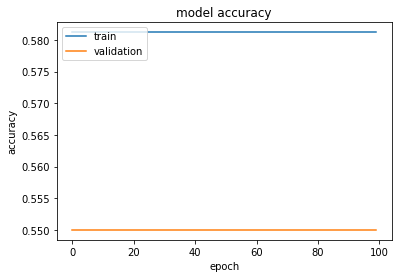

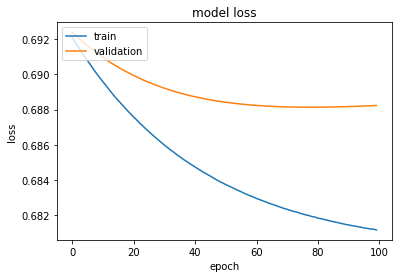

In [19]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [34]:
history = model.fit_generator(v_generator,
                              epochs=100, validation_data=validation_generator)

Epoch 1/100
59/59 [==============================] - 83s 1s/step - loss: 0.6862 - binary_accuracy: 0.6441 - val_loss: 0.6909 - val_binary_accuracy: 0.5500
Epoch 2/100
59/59 [==============================] - 64s 1s/step - loss: 0.6858 - binary_accuracy: 0.6441 - val_loss: 0.6908 - val_binary_accuracy: 0.5500
Epoch 3/100
59/59 [==============================] - 69s 1s/step - loss: 0.6854 - binary_accuracy: 0.6441 - val_loss: 0.6907 - val_binary_accuracy: 0.5500
Epoch 4/100
59/59 [==============================] - 71s 1s/step - loss: 0.6850 - binary_accuracy: 0.6441 - val_loss: 0.6906 - val_binary_accuracy: 0.5500
Epoch 5/100
59/59 [==============================] - 65s 1s/step - loss: 0.6846 - binary_accuracy: 0.6441 - val_loss: 0.6904 - val_binary_accuracy: 0.5500
Epoch 6/100
59/59 [==============================] - 66s 1s/step - loss: 0.6842 - binary_accuracy: 0.6441 - val_loss: 0.6903 - val_binary_accuracy: 0.5500
Epoch 7/100
59/59 [==============================] - 64s 1s/step - los